## Set up

In [1]:
!pip install transformers==4.40.2
!pip install accelerate
!pip install hf_xet
!pip install datasets
!pip install bert-score
!pip install blobfile tiktoken
!pip install torch
!pip install datasets==3.6.0
!pip install huggingface_hub==0.32.0
!pip install sentencepiece
#!pip install transformers==4.35.2 tokenizers==0.14.1 huggingface_hub==0.16.4 accelerate==0.26.1

  Using cached transformers-4.40.2-py3-none-any.whl.metadata (137 kB)
  Using cached tokenizers-0.19.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached transformers-4.40.2-py3-none-any.whl (9.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 11.5 MB/s eta 0:00:00a 0:00:01
Using cached tokenizers-0.19.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [transformers] [transformers]ub]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 10.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13/13 [datasets]/13 [datasets]ess]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 9.7 MB/s eta 0:00:00a 0:00:01
   ━━━━

## Load the Model & Dataset

In [2]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

model = AutoModelForSeq2SeqLM.from_pretrained("KETI-AIR/ke-t5-base-ko").to("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(
    "KETI-AIR/ke-t5-base-ko", 
    use_fast=False, 
    trust_remote_code=True,
    legacy=False
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
from datasets import load_dataset

dataset = load_dataset(
    "csv",
    data_files="Data_filtered.csv",
    encoding="utf-8",
    split={
        "train": "train[:80%]",
        "validation": "train[80%:90%]",
        "test": "train[90%:]"
    }
)

dataset = dataset.filter(lambda x: x["ko_translationese"] is not None and x["ko"] is not None)

Generating train split: 0 examples [00:00, ? examples/s]

## Preprocessing

In [ ]:
def preprocess(example):
    # 프롬프트 형태를 명시적으로 포함
    input_text = "번역투 완화: " + example["ko_translationese"]
    target_text = example["ko"]

    model_inputs = tokenizer(input_text, max_length=128, truncation=True, padding="max_length")
    labels = tokenizer(target_text, max_length=128, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess, batched=False)

Map:   0%|          | 0/85594 [00:00<?, ? examples/s]

### Fine Tuning

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    label_pad_token_id=-100 
)

training_args = Seq2SeqTrainingArguments(
    output_dir="./ke-t5-translationese-mitigation",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    learning_rate=5e-5,
    warmup_ratio=0.1,
    predict_with_generate=True,
    logging_dir="./logs",
    save_total_limit=2,
    logging_steps=1000,
    evaluation_strategy="steps",
    eval_steps=1000,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [62]:
trainer.train()

Step,Training Loss,Validation Loss
1000,155.316800,95.147331
2000,87.125400,34.044762
3000,10.687900,1.628902
4000,1.615800,1.438149
5000,1.391600,1.082923
6000,1.060800,0.706245
7000,0.796300,0.567908
8000,0.674000,0.521763
9000,0.609700,0.490314
10000,0.577800,0.471900


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [469]:
import pandas as pd

log_history = trainer.state.log_history
log_df = pd.DataFrame(log_history)
log_df.head()

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.2545,0.190344,0.000047,0.186916,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.186916,1000,0.236802,62.7818,170.416,10.656,NaN,NaN,NaN,NaN,NaN
2,0.2402,0.244009,0.000045,0.373832,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.373832,2000,0.236675,62.6919,170.660,10.671,NaN,NaN,NaN,NaN,NaN
4,0.2411,0.224249,0.000040,0.560748,3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


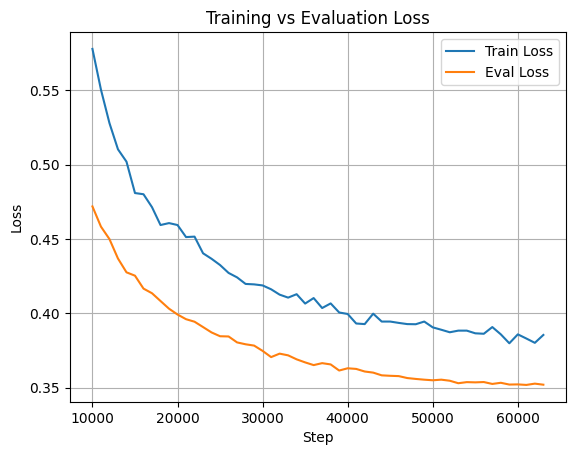

In [ ]:
import matplotlib.pyplot as plt

# step ≥ 10000 이후 데이터만 필터링
train_loss = log_df[(log_df["loss"].notnull()) & (log_df["step"] >= 10000)]
eval_loss = log_df[(log_df["eval_loss"].notnull()) & (log_df["step"] >= 10000)]

# 스텝 기준 선 그래프
plt.plot(train_loss["step"], train_loss["loss"], label="Train Loss")
plt.plot(eval_loss["step"], eval_loss["eval_loss"], label="Eval Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [471]:
final_metrics = trainer.evaluate()
print(final_metrics)

The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: ko_translationese, ko, similarity, en. If ko_translationese, ko, similarity, en are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 10699
  Batch size = 16


{'eval_loss': 0.2299094945192337, 'eval_runtime': 62.7029, 'eval_samples_per_second': 170.63, 'eval_steps_per_second': 10.669, 'epoch': 2.0}


## Evaluation

#### KoBERT score

In [477]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
import numpy as np

similarity_model = AutoModel.from_pretrained("monologg/kobert")
similarity_tokenizer = AutoTokenizer.from_pretrained("monologg/kobert", trust_remote_code=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
similarity_model = similarity_model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--monologg--kobert/snapshots/38279184ba645e8c94d709fbe92eb5bcb47312c1/config.json
Model config BertConfig {
  "_name_or_path": "monologg/kobert",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.2",

In [478]:
def get_similarity_batch(texts1, texts2, batch_size=8):
    results = []
    for i in range(0, len(texts1), batch_size):
        batch1 = texts1[i:i+batch_size]
        batch2 = texts2[i:i+batch_size]

        with torch.no_grad():
            tokens1 = similarity_tokenizer(batch1, return_tensors="pt", truncation=True, padding=True, max_length=None).to(device)
            tokens2 = similarity_tokenizer(batch2, return_tensors="pt", truncation=True, padding=True, max_length=None).to(device)

            emb1 = similarity_model(**tokens1).last_hidden_state.mean(dim=1)
            emb2 = similarity_model(**tokens2).last_hidden_state.mean(dim=1)

            batch_scores = F.cosine_similarity(emb1, emb2)
            batch_scores = torch.clamp(batch_scores, max=1.0)
            results.extend(batch_scores.cpu().numpy().tolist())
    return results
    
def compute_metrics_kobert(eval_preds):
    preds, labels = eval_preds

    if isinstance(preds, tuple):
        preds = preds[0]

    if preds.ndim == 3:
        preds = np.argmax(preds, axis=-1)

    labels = np.array(labels)

    def remove_padding(token_ids):
        return [token for token in token_ids if token != -100]

    preds = [remove_padding(p) for p in preds]
    labels = [remove_padding(l) for l in labels]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    try:
        scores = get_similarity_batch(decoded_preds, decoded_labels)
    except Exception as e:
        print(f"Similarity error: {e}")
        scores = [0.0] * len(decoded_preds)

    return {
        "avg_similarity": float(np.mean(scores)),
        "max_similarity": float(np.max(scores)),
        "min_similarity": float(np.min(scores)),
    }

In [479]:
test_dataset_sampled = tokenized_dataset["test"].select(range(1000))

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    label_pad_token_id=-100 
)

training_args = Seq2SeqTrainingArguments(
    output_dir="./ke-t5-translationese-mitigation",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    learning_rate=5e-5,
    warmup_ratio=0.1,
    logging_dir="./logs",
    save_total_limit=2,
    logging_steps=1000,
    evaluation_strategy="steps",
    eval_steps=1000,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=test_dataset_sampled,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_kobert
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [482]:
# ko vs. mitigated 
eval_results = trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: ko_translationese, ko, similarity, en. If ko_translationese, ko, similarity, en are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 10699
  Batch size = 8


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.65 GiB. GPU 

In [ ]:
test_dataset_sample = dataset["test"].shuffle(seed=1023).select(range(1000))

In [488]:
from tqdm import tqdm

# ko_translationese 입력 문장
source_texts = test_dataset_sample["ko_translationese"]
reference_texts = test_dataset_sample["ko"]

# 생성 결과 저장용
mitigated_texts = []

model.eval()
for i in tqdm(range(0, len(source_texts), 4)):  # 소량 batch로 쪼개서 메모리 절약
    batch = source_texts[i:i+4]
    inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=512).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            temperature=0.9,
            top_p=0.4,
            repetition_penalty=1.2,
            do_sample=True,
            no_repeat_ngram_size=3,
            decoder_start_token_id = model.config.decoder_start_token_id
        )

    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    mitigated_texts.extend(decoded)

100%|██████████| 250/250 [01:22<00:00,  3.04it/s]


In [ ]:
# ko vs. mitigated
similarities = get_similarity_batch(reference_texts, mitigated_texts)

print(f"KoBERT avg similarity: {np.mean(similarities):.4f}")
print(f"KoBERT max similarity: {np.max(similarities):.4f}")
print(f"KoBERT min similarity: {np.min(similarities):.4f}")

KoBERT avg similarity: 0.8123
KoBERT max similarity: 0.9786
KoBERT min similarity: 0.4497


In [490]:
# ko vs. translated_ko
similarities = get_similarity_batch(test_dataset_sample['ko'], test_dataset_sample['ko_translationese'])

print(f"KoBERT avg similarity: {np.mean(similarities):.4f}")
print(f"KoBERT max similarity: {np.max(similarities):.4f}")
print(f"KoBERT min similarity: {np.min(similarities):.4f}")

KoBERT avg similarity: 0.8696
KoBERT max similarity: 1.0000
KoBERT min similarity: 0.5580


#### Perplexity

In [491]:
# ko vs. mitigated
import math
if "eval_loss" in eval_results:
    ppl = math.exp(eval_results["eval_loss"])
    print(f"Perplexity: {ppl:.2f}")

Perplexity: 1.26


### MATTR

In [364]:
generated_texts = [s for s in mitigated_texts if len(s.strip().split()) > 0]

In [367]:
from collections import Counter

# window size로 ttr 계산 범위 조정  
def mattr(text, window_size=50):
    tokens = text.split()
    if len(tokens) < window_size:
        return len(set(tokens)) / len(tokens)
    
    ttr_list = []
    for i in range(len(tokens) - window_size + 1):
        window = tokens[i:i + window_size]
        ttr_list.append(len(set(window)) / window_size)
    
    return sum(ttr_list) / len(ttr_list)

In [ ]:
original_texts = dataset['test']['ko']
total_mattr_original = 0
for sent in original_texts:
    total_mattr_original += mattr(sent, window_size=50)

average_mattr_original = total_mattr_original / len(original_texts)
print(f"Average MATTR of Original Texts: {average_mattr_original:.4f}")

Average MATTR of Original Texts: 0.9961


In [ ]:
translationese_texts = dataset['test']['ko_translationese']
total_mattr_translationese = 0

for sent in translationese_texts:
    total_mattr_translationese += mattr(sent, window_size=50)

average_mattr_translationese = total_mattr_translationese / len(translationese_texts)
print(f"Average MATTR of Translationese Texts: {average_mattr_translationese:.4f}")

Average MATTR of Translationese Texts: 0.9941


In [374]:
total_mattr_mitigated = 0
for sent in generated_texts:
    total_mattr_mitigated += mattr(sent, window_size=50)

average_mattr_mitigated = total_mattr_mitigated / len(generated_texts)
print(f"Average MATTR of Mitigated Texts: {average_mattr_mitigated:.4f}")

Average MATTR of Mitigated Texts: 0.9977
